## Classify whether images contain either a dog or a cat with Deep Learning

- Data source： https://www.kaggle.com/c/dogs-vs-cats 

In [1]:
import cv2 # pip3 install opencv-python
import numpy as np 
import os 
from random import shuffle  
from tqdm import tqdm 
import matplotlib.pyplot as plt 

In [2]:
train_dir = 'train/'
test_dir = 'test/'
img_size = 50
lr = 1e-3

Change label to dummy variables

In [3]:
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'cat': return [1,0]
    elif word_label == 'dog': return [0,1]

In [4]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(train_dir)):
        if (not img.endswith('.jpg')):
            continue
        label = label_img(img)
        path = os.path.join(train_dir, img)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  
        img = cv2.resize(img, (img_size, img_size) )  # Make them the same size
        training_data.append([np.array(img), np.array(label)])
    shuffle(training_data)
    return training_data
        

In [5]:
train_data = create_train_data()

100%|██████████| 25000/25000 [00:32<00:00, 758.78it/s]


Process test data

In [6]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(test_dir)):
        if (not img.endswith('.jpg')):
            continue
        path = os.path.join(test_dir,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    return testing_data

In [7]:
import tflearn 
from tflearn.layers.conv import conv_2d, max_pool_2d  
from tflearn.layers.core import input_data, dropout, fully_connected 
from tflearn.layers.estimator import regression # cross entropy

/Users/yongqiangshen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
import tensorflow as tf
tf.reset_default_graph()

In [9]:
convnet = input_data(shape = [None, img_size, img_size, 1], name = 'input')

In [10]:
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

In [11]:
convnet = fully_connected(convnet, 1024, activation = 'relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate = lr, loss='categorical_crossentropy', name='targets')

In [12]:
model = tflearn.DNN(convnet, tensorboard_dir='log')

In [13]:
train = train_data[:-500]

In [14]:
test = train_data[-500:]

In [15]:
X = np.array([i[0] for i in train], dtype=np.float64).reshape(-1, img_size, img_size, 1)
y = np.array([i[1] for i in train], dtype=np.float64)
Xtest = np.array([i[0] for i in test], dtype=np.float64).reshape(-1, img_size, img_size, 1)
ytest = np.array([i[1] for i in test], dtype=np.float64)

Train data

In [16]:
model.fit({'input': X}, {'targets': y}, n_epoch=3, validation_set=({'input': Xtest}, {'targets': ytest}), snapshot_step=500, show_metric=True, run_id='model' )

Training Step: 1148  | total loss: 0.47939 | time: 37.099s
| Adam | epoch: 003 | loss: 0.47939 - acc: 0.7693 -- iter: 24448/24500
Training Step: 1149  | total loss: 0.47966 | time: 38.202s
| Adam | epoch: 003 | loss: 0.47966 - acc: 0.7689 | val_loss: 0.54378 - val_acc: 0.7300 -- iter: 24500/24500
--


Test data

In [17]:
test_data = process_test_data()

100%|██████████| 12500/12500 [00:14<00:00, 877.29it/s]


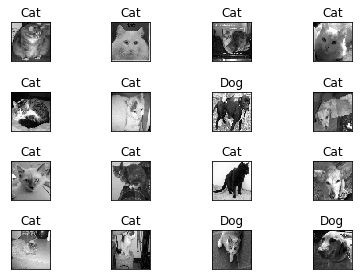

In [18]:
fig = plt.figure()
for num,data in enumerate(test_data[:16]):
    img_num = data[1]
    img_data = data[0]
    y = fig.add_subplot(4, 4, num+1)
    orig = img_data
    data = img_data.reshape(img_size, img_size, 1)
    model_out = model.predict([data])[0]
    if np.argmax(model_out) == 1: 
        label = 'Dog'
    else: 
        label = 'Cat'
    
    y.imshow(orig, cmap='gray')
    plt.title(label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    
plt.tight_layout()
plt.show()